Example: Genetic Determinants of Neuronal Morphology
====================================================
We will illustrate the utility of the Laplacian score in identifying genes that
contribute to the neuronal plasticity in the C. elegans. This example utilizes a dataset consisting of 799 3D neuronal reconstructions of the C.elegans DVB neuron across various mutant and control strains during days 1 to 5 of adulthood. The dataset can be downloaded from the following
[folder](https://www.dropbox.com/scl/fo/y7axeardkwyn1d6j97dqr/h?dl=0&rlkey=4b65w4tc93e778rql72d275ym). The DVB neuron is an excitatory GABAergic motor
interneuron located in the dorso-rectal ganglion of the worm, and is known to undergo post-developmental neurite outgrowth in males. This outgrowth 
alters the neuron's morphology and synaptic connectivity, contributing to
changes in the spicule protraction step of male mating behavior. More information about this 
dataset can be found at:

\- Hart, M. P. & Hobert, O. [Neurexin controls plasticity of a mature, sexually dimorphic neuron.](https://www.nature.com/articles/nature25192) Nature 553, 165-170, (2018).

\- Govek, K. W. et al. [Analysis and integration of single-cell morphological data using metric geometry.](https://www.biorxiv.org/content/10.1101/2022.05.19.492525v3) (2022). DOI: 10.1101/2022.05.19.492525 (bioRxiv).

To begin our analysis, we calculate the Gromov-Wasserstein distance between each pair of cells. This computation typically requires 20-30 minutes to complete on a standard desktop computer.

In [68]:
import cajal.sample_swc
import cajal.swc
import cajal.run_gw

cajal.sample_swc.compute_icdm_all_geodesic(
    infolder="CAJAL/data_worm/swc/",
    out_csv="CAJAL/data_worm/c_elegans_icdm.csv",
    preprocess=cajal.swc.preprocessor_geo(
        structure_ids="keep_all_types"),
    n_sample=50,
    num_cores=8)

cajal.run_gw.compute_gw_distance_matrix(
    "CAJAL/data_worm/c_elegans_icdm.csv",
    "CAJAL/data_worm/c_elegans_gw_dist.csv")

1
101
201
301
401
501
601
701
Computation finished. Computed 318801 cell pairs. Time elapsed: 1676.9282417297363


We can generate a UMAP plot that visualizes the cell morphology space, with each point colored according to the age of each worm in days. The metadata for each neuron in this example is provided in the file ```CAJAL/data/c_elegans_features.csv```, which can be found in the GitHub repository of CAJAL. This metadata includes information such as the age of the worm in days and the genotype of each gene (0: wild-type; 1: mutant).

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



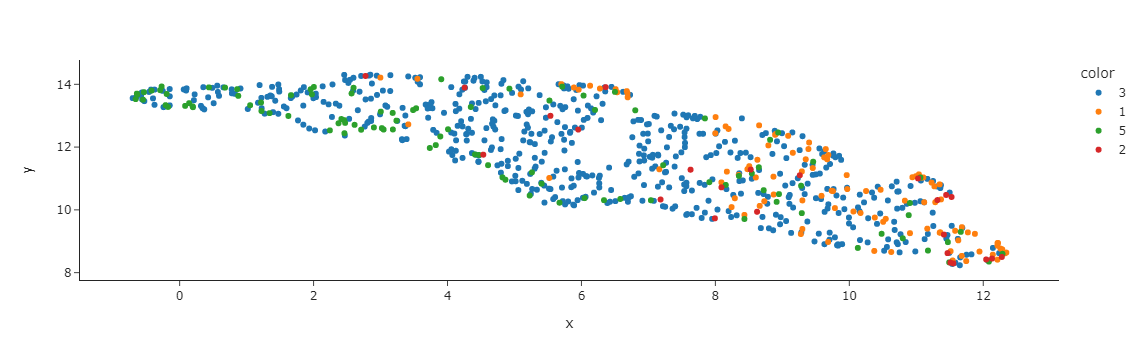

In [38]:
import cajal.utilities
import umap
import pandas
import plotly.express
import plotly.io
from scipy.spatial.distance import squareform

# Read GW distance matrix
cells, gw_dist_dict = cajal.utilities.read_gw_dists("CAJAL/data_worm/c_elegans_gw_dist.csv", header=True)
gw_dist_vec = cajal.utilities.dist_mat_of_dict(gw_dist_dict)
gw_dist = squareform(gw_dist_vec)

# Compute UMAP representation
reducer = umap.UMAP(metric="precomputed", random_state=1)
embedding = reducer.fit_transform(gw_dist)

# Download metadata
metadata = pandas.read_csv("CAJAL/data_worm/c_elegans_features.csv", index_col = "cell_name")

# Visualize UMAP
#plotly.io.renderers.default = 'iframe'
plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells],
                       color = [str(m) for m in metadata["day"]])

Unsurprisingly, the age of the worm plays a significant role in shaping the morphology of its neurons. This is evident in the UMAP representation above, which reveals that neurons of different ages cluster in distinct regions of the UMAP. To quantify this association, we can use the Laplacian score:

In [70]:
import cajal.laplacian_score
import numpy

laplacian = pandas.DataFrame(cajal.laplacian_score.laplacian_scores(numpy.array(metadata["day"]).reshape(799,1), 
                                       gw_dist_vec, 
                                       numpy.median(gw_dist_vec), 
                                       permutations = 5000, 
                                       covariates = None, 
                                       return_random_laplacians = False)[0])

print(laplacian)

   feature_laplacians  laplacian_p_values  laplacian_q_values
0            0.948812              0.0002              0.0002


A very small p value suggests a strong association between the age of the worm and the morphology of the DVB neuron.

Moving forward, our goal is to identify mutations that impact the morphology of the DVB neuron. To achieve this, we will rely on the Laplacian score once again. However, it is essential to consider the unequal representation of worms with a given genotype across different ages in the dataset. To address this issue, we will account for the uneven distribution of ages for each genotype. As an example, we will investigate the impact of deleterious mutations in the unc-25 gene. Let us first look at their distribution in the cell morphology space:

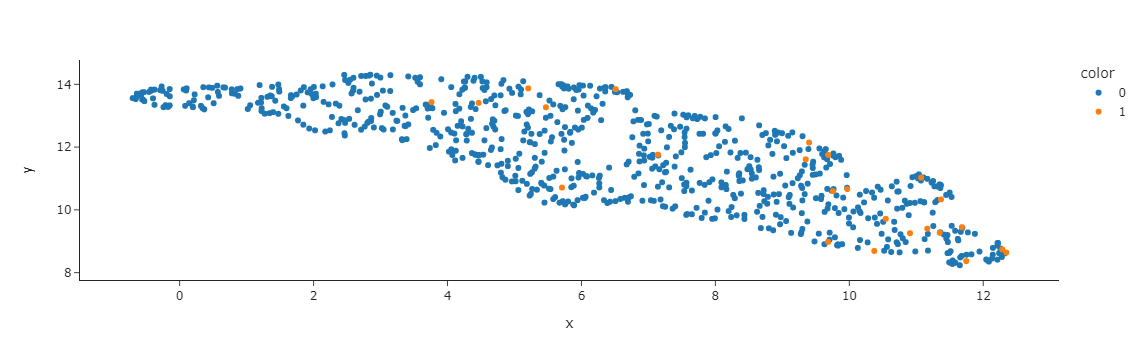

In [71]:
plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells],
                       color = [str(m) for m in metadata["unc-25"]])

The UMAP representation reveals that cells with a deleterious mutation in unc-25 exhibit similar morphology, a finding supported by the small p-value of the Laplacian score of unc-25 in the cell morphology space:

In [72]:
laplacian = pandas.DataFrame(cajal.laplacian_score.laplacian_scores(numpy.array(metadata["unc-25"]).reshape(799,1), 
                                       gw_dist_vec, 
                                       numpy.median(gw_dist_vec), 
                                       permutations = 5000, 
                                       covariates = None, 
                                       return_random_laplacians = False)[0])

print(laplacian)

   feature_laplacians  laplacian_p_values  laplacian_q_values
0            0.992825            0.002599            0.002599


However, most of the samples with a mutation in unc-25 were obrained from worms with ages 1 or 3 days:

In [73]:
metadata.loc[metadata["unc-25"]==1,"day"].value_counts()

1    18
3     6
Name: day, dtype: int64

This leads to the question: is the comparable morphology of neurons with a deleterious mutation in unc-25 attributed to the mutation itself or the similar age of the worms? To address this issue, we can employ the Laplacian score but treating the age of the worm as a covariate:

In [50]:
laplacian = pandas.DataFrame(cajal.laplacian_score.laplacian_scores(numpy.array(metadata.iloc[:,0:11]), 
                                       gw_dist_vec, 
                                       numpy.median(gw_dist_vec), 
                                       permutations = 5000, 
                                       covariates = numpy.array(metadata["day"]), 
                                       return_random_laplacians = False)[0])
laplacian.index = metadata.columns.values.tolist()[0:11]

print(laplacian)

        feature_laplacians  laplacian_p_values  laplacian_q_values    beta_0  \
nrx-1             0.994212            0.005199            0.009531  0.988246   
mir-1             0.997844            0.166567            0.203582  1.003280   
unc-49            0.993766            0.003199            0.007039  0.997068   
nlg-1             0.991764            0.001000            0.004399  0.962229   
unc-25            0.992825            0.001800            0.004949  0.932372   
unc-97            0.959125            0.000200            0.002200  0.992651   
lim-6             0.998643            0.355129            0.390642  1.004014   
lat-2             0.990617            0.001000            0.004399  0.988813   
ptp-3             0.997204            0.093381            0.128399  0.982372   
sup-17            0.995560            0.022196            0.034879  0.992381   
pkd-2             0.999328            0.582284            0.582284  0.973606   

          beta_1  beta_1_p_value  regre

Upon examining the table, we note that the q-value of unc-25 shifts from 0.005 to 0.06 after adjusting for the covariate effect. Consistent with this, the F-statistic suggests a considerable impact of the covariate on the Laplacian score of unc-25, as evidenced by the low p-value of the F-statistic.